In [1]:
import pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
series = ["IBM", "AAPL", "GOOGL", "AMZN"]

In [244]:
df = pd.DataFrame()
for s in series:
    serie = pd.read_csv("./dataset/{}_2006-01-01_to_2018-01-01.csv".format(s))
    df[s] = serie.Close
df.index = pd.date_range("2006-01-01","2018-01-01", freq = pd.tseries.offsets.BusinessDay() )

In [3]:
import yfinance as yf

In [4]:
data = yf.download(series, start="2006-01-01", end="2018-01-01")
data = data["Close"]

[*********************100%***********************]  4 of 4 completed


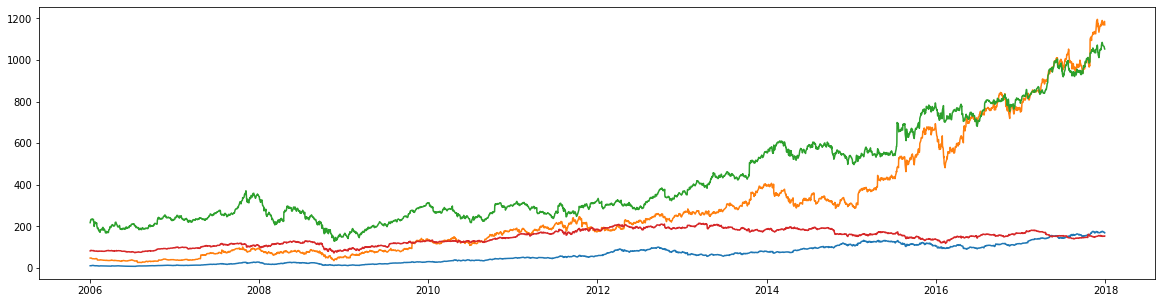

In [5]:
fig, ax = plt.subplots(figsize = (20,5))
plt.plot(data)

In [6]:
import numpy as np

In [7]:
def rolling_window(a, window, step_size):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1 - step_size + 1, window)
    strides = a.strides + (a.strides[-1] * step_size,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [8]:
# Ejemplo
rango = np.arange(10)
rolling_window(rango, 5, 1)

array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8],
       [5, 6, 7, 8, 9]])

In [263]:
'''def ts_to_rolling_df(time_series, window):
    ts_rolling = rolling_window(time_series, window, 1)
    target = ts_rolling[:,-1]/ts_rolling[:,-2]
    ts_dataset = np.column_stack((ts_rolling,target))
    df = pd.DataFrame(ts_dataset)
    df["Target"] = df[df.columns[-1]]
    df = df.drop(columns = df.columns[-2])
    return df
'''
#data = ts_to_rolling_df(data, SEQ_LENGTH)

'def ts_to_rolling_df(time_series, window):\n    ts_rolling = rolling_window(time_series, window, 1)\n    target = ts_rolling[:,-1]/ts_rolling[:,-2]\n    ts_dataset = np.column_stack((ts_rolling,target))\n    df = pd.DataFrame(ts_dataset)\n    df["Target"] = df[df.columns[-1]]\n    df = df.drop(columns = df.columns[-2])\n    return df\n'

In [34]:
SEQ_LENGTH = 10
series_rolling = {}
for serie in data:
    serie_r = rolling_window(data[serie].values.T, SEQ_LENGTH + 1, 1)
    serie_r = pd.DataFrame(serie_r, index = data[serie].index[SEQ_LENGTH:])
    serie_r["Target"] = serie_r[SEQ_LENGTH]
    serie_r = serie_r.drop(columns = serie_r.columns[-2])
    series_rolling[serie] = serie_r 

In [35]:
statistics = {}
series_rolling_norm = {}
for s in series_rolling:
    df = series_rolling.get(s)
    statistics[s] = {"mean" : df["Target"].mean(), "std" : df["Target"].std()}
    series_rolling_norm[s] = (df - df.mean())/df.std()

In [224]:
data = (data - data.mean())/data.std()

In [302]:

list(series_rolling_norm.values())[1].head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,Target
0,-0.913833,-0.915333,-0.913988,-0.913342,-0.916610,-0.922331,-0.925295,-0.927675,-0.927700,-0.929412,...,-0.958811,-0.957830,-0.958847,-0.958485,-0.959574,-0.960284,-0.961012,-0.959368,-0.957044,-0.955767
1,-0.915115,-0.913782,-0.913136,-0.916399,-0.922138,-0.925111,-0.927494,-0.927521,-0.929239,-0.928182,...,-0.957943,-0.958950,-0.958558,-0.959637,-0.960328,-0.961074,-0.959436,-0.957114,-0.955793,-0.956267
2,-0.913561,-0.912929,-0.916197,-0.921933,-0.924921,-0.927312,-0.927339,-0.929062,-0.928007,-0.927682,...,-0.959065,-0.958661,-0.959712,-0.960393,-0.961119,-0.959495,-0.957178,-0.955861,-0.956293,-0.957658
3,-0.912707,-0.915993,-0.921737,-0.924719,-0.927124,-0.927158,-0.928882,-0.927829,-0.927507,-0.929719,...,-0.958775,-0.959816,-0.960469,-0.961185,-0.959538,-0.957233,-0.955924,-0.956362,-0.957687,-0.955410
4,-0.915775,-0.921539,-0.924526,-0.926925,-0.926970,-0.928702,-0.927648,-0.927329,-0.929546,-0.930449,...,-0.959933,-0.960574,-0.961262,-0.959601,-0.957273,-0.955977,-0.956425,-0.957758,-0.955436,-0.953377


In [11]:
def series_split(features, target, test_size):
    total = features.shape[0]
    n = int(total*(1 - test_size))
    return features[:n], features[n:], target[:n], target[n:]

In [12]:
def unstandarize(predictions,statistics):
    for p in predictions:
        t = p[:-5] 
        predictions[p] = predictions[p]*statistics[t]["std"] + statistics[t]["mean"]
    return predictions

In [13]:
statistics

{'AAPL': {'mean': 65.194224034185, 'std': 44.42434896596139},
 'AMZN': {'mean': 301.89122764689466, 'std': 280.1670275116227},
 'GOOGL': {'mean': 430.1771034113141, 'std': 236.48254516307261},
 'IBM': {'mean': 146.25648827951488, 'std': 37.1668786334069}}

In [453]:
pred_unstd = unstandarize(predictions,statistics)
pred_unstd = pred_unstd.add_suffix("_pred")

In [454]:
pred_unstd.index = data.index[-977:]

In [449]:
series_rolling.get("AAPL").values[:,-1].mean()

65.75939184523918

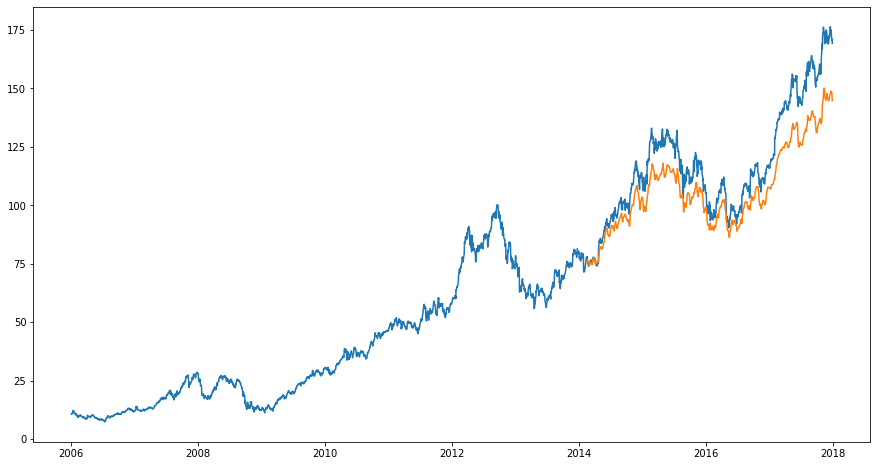

In [455]:
fig, ax = plt.subplots(figsize = (15,8))
plt.plot(data.AAPL)
plt.plot(pred_unstd.AAPL_pred)

In [18]:
def reshape_values(X_train, X_test):
    X_train = X_train.values.reshape((X_train.shape[0],X_train.shape[1],1))
    X_test = X_test.values.reshape((X_test.shape[0],X_test.shape[1],1))
    return X_train, X_test

In [114]:
#https://medium.com/@dclengacher/keras-lstm-recurrent-neural-networks-c1f5febde03d

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import Adam
#https://stats.stackexchange.com/questions/264546/difference-between-samples-time-steps-and-features-in-neural-network



def create_Conv1D_model():
    seq_length = SEQ_LENGTH
    kernel = 3  
    model = Sequential()
    model.add(Conv1D(32, kernel_size= kernel, activation='relu', input_shape=(seq_length,1)))
    model.add(Dropout(0.3))
    model.add(Conv1D(64, kernel_size= kernel, activation='relu'))
    model.add(Dropout(0.3))
    #model.add(MaxPooling1D(kernel))
    model.add(Conv1D(64, kernel_size= kernel, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(128, kernel_size= kernel, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    opt = Adam(lr=0.001)

    model.compile(loss='mean_squared_error',
                  optimizer= opt)  
    return model



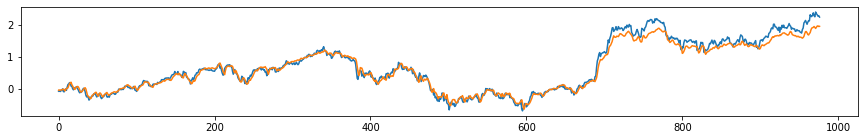

In [233]:
n = len(x)
x = np.arange(y_test.shape[0])
fig, ax = plt.subplots( figsize = (15,2))
plt.plot(x[:n] ,y_test[:n] )
plt.plot(x[:n] ,y_predicted[:n] )

In [508]:
a, b = reshape_values(X_train,X_test)


In [16]:

def train_all(series_rolling):
    models = {}
    predictions = pd.DataFrame()
    scores = {}
    for s in series_rolling:
        data = series_rolling[s]
        features = data.drop(columns = "Target")
        target = data["Target"]
        X_train, X_test, y_train, y_test = series_split(features, target, test_size=0.33)
        X_train_r, X_test_r = reshape_values(X_train, X_test)
        model = create_Conv1D_model()
        history = model.fit(X_train_r, y_train, batch_size=32, epochs=40, validation_data=(X_test_r,y_test))
        score = model.evaluate(X_test_r, y_test, batch_size=16)
        print(s," = ", score)
        pred = model.predict(X_test_r)
        scores[s] = score
        predictions[s] = pred.flatten()
        models[s] = model
    predictions.index = y_test.index
    predictions = predictions.add_suffix("_pred")
    return models, predictions, scores
    

In [36]:
models_norm, predictions_norm, scores_norm = train_all(series_rolling_norm)

Train on 2016 samples, validate on 994 samples
Epoch 1/40
2016/2016 [==============================] - 1s 249us/step - loss: 0.0898 - val_loss: 0.0151
Epoch 2/40
2016/2016 [==============================] - 0s 79us/step - loss: 0.0125 - val_loss: 0.0278
Epoch 3/40
2016/2016 [==============================] - 0s 73us/step - loss: 0.0094 - val_loss: 0.0207
Epoch 4/40
2016/2016 [==============================] - 0s 75us/step - loss: 0.0082 - val_loss: 0.0613
Epoch 5/40
2016/2016 [==============================] - 0s 73us/step - loss: 0.0079 - val_loss: 0.0504
Epoch 6/40
2016/2016 [==============================] - 0s 72us/step - loss: 0.0069 - val_loss: 0.0992
Epoch 7/40
2016/2016 [==============================] - 0s 74us/step - loss: 0.0062 - val_loss: 0.0398
Epoch 8/40
2016/2016 [==============================] - 0s 72us/step - loss: 0.0064 - val_loss: 0.0992
Epoch 9/40
2016/2016 [==============================] - 0s 71us/step - loss: 0.0057 - val_loss: 0.1276
Epoch 10/40
2016/2016 [==

2016/2016 [==============================] - 0s 86us/step - loss: 0.0010 - val_loss: 0.8197
Epoch 39/40
2016/2016 [==============================] - 0s 72us/step - loss: 0.0010 - val_loss: 0.8584
Epoch 40/40
994/994 [==============================] - 0s 28us/step
AMZN  =  0.5711447530680466
Train on 2016 samples, validate on 994 samples
Epoch 1/40
2016/2016 [==============================] - 1s 255us/step - loss: 0.0670 - val_loss: 1.8476
Epoch 2/40
2016/2016 [==============================] - 0s 77us/step - loss: 0.0122 - val_loss: 0.2398
Epoch 3/40
2016/2016 [==============================] - 0s 83us/step - loss: 0.0087 - val_loss: 0.0074
Epoch 4/40
2016/2016 [==============================] - 0s 72us/step - loss: 0.0068 - val_loss: 0.0253
Epoch 5/40
2016/2016 [==============================] - 0s 73us/step - loss: 0.0062 - val_loss: 0.0076
Epoch 6/40
2016/2016 [==============================] - 0s 70us/step - loss: 0.0058 - val_loss: 0.0086
Epoch 7/40
2016/2016 [====================

2016/2016 [==============================] - 0s 74us/step - loss: 0.0109 - val_loss: 0.0146
Epoch 35/40
2016/2016 [==============================] - 0s 70us/step - loss: 0.0113 - val_loss: 0.0094
Epoch 36/40
2016/2016 [==============================] - 0s 70us/step - loss: 0.0127 - val_loss: 0.0102
Epoch 37/40
2016/2016 [==============================] - 0s 72us/step - loss: 0.0107 - val_loss: 0.0122
Epoch 38/40
2016/2016 [==============================] - 0s 74us/step - loss: 0.0111 - val_loss: 0.0113
Epoch 39/40
2016/2016 [==============================] - 0s 76us/step - loss: 0.0095 - val_loss: 0.0123
Epoch 40/40
994/994 [==============================] - 0s 32us/step
IBM  =  0.008488562956388657


In [37]:
predictions_recovered = unstandarize(predictions_norm, statistics)
answer_recovered = pd.merge(data,predictions_recovered,left_index = True, right_index = True)

In [38]:
answer_recovered.to_csv("predictions_stock-market-length-{}.csv".format(SEQ_LENGTH))

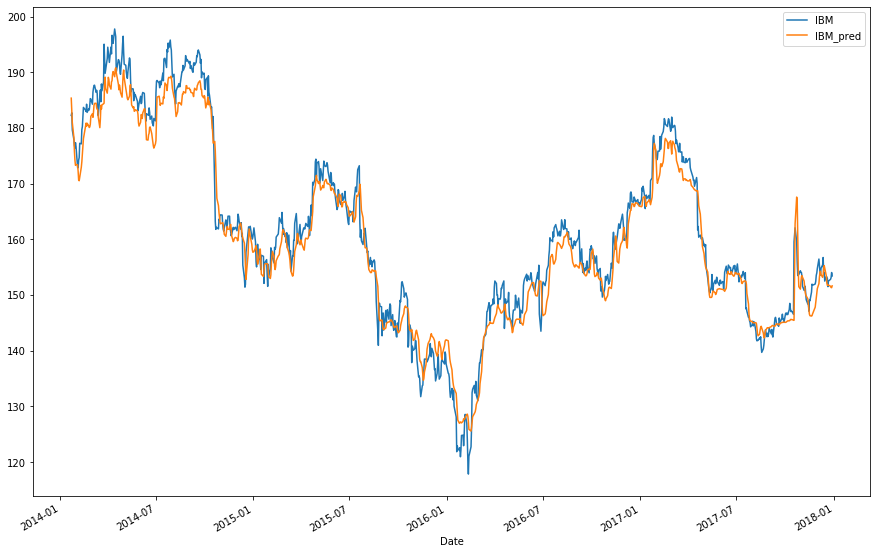

In [39]:
fig, ax = plt.subplots( figsize = (15,10))
answer_recovered[["IBM", "IBM_pred"]].plot(fig = fig, ax = ax, legend=True)

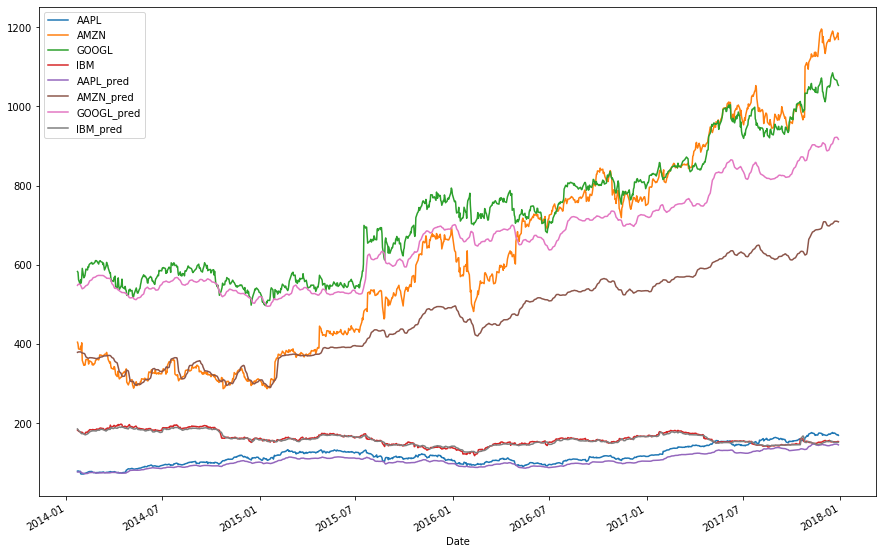

In [40]:
fig, ax = plt.subplots( figsize = (15,10))
answer_recovered.plot(fig = fig, ax = ax, legend=True)

In [543]:
models, predictions, scores = train_all(series_rolling)

Train on 1983 samples, validate on 977 samples
Epoch 1/40
1983/1983 [==============================] - 1s 532us/step - loss: 132.2154 - val_loss: 1187.0207
Epoch 2/40
1983/1983 [==============================] - 1s 350us/step - loss: 30.9410 - val_loss: 1779.5979
Epoch 3/40
1983/1983 [==============================] - 1s 357us/step - loss: 27.2569 - val_loss: 1739.6441
Epoch 4/40
1983/1983 [==============================] - 1s 351us/step - loss: 24.5691 - val_loss: 2429.7260
Epoch 5/40
1983/1983 [==============================] - 1s 342us/step - loss: 21.3259 - val_loss: 1910.3248
Epoch 6/40
1983/1983 [==============================] - 1s 353us/step - loss: 19.5130 - val_loss: 2619.8307
Epoch 7/40
1983/1983 [==============================] - 1s 351us/step - loss: 18.5770 - val_loss: 2648.8370
Epoch 8/40
1983/1983 [==============================] - 1s 351us/step - loss: 19.4879 - val_loss: 3018.5518
Epoch 9/40
1983/1983 [==============================] - 1s 371us/step - loss: 17.1059 - 

Epoch 34/40
1983/1983 [==============================] - 1s 352us/step - loss: 197.7171 - val_loss: 81256.0564
Epoch 35/40
1983/1983 [==============================] - 1s 361us/step - loss: 152.9494 - val_loss: 91597.3011
Epoch 36/40
1983/1983 [==============================] - 1s 354us/step - loss: 139.1377 - val_loss: 81448.6870
Epoch 37/40
1983/1983 [==============================] - 1s 400us/step - loss: 170.6197 - val_loss: 102074.7226
Epoch 38/40
1983/1983 [==============================] - 1s 413us/step - loss: 202.4471 - val_loss: 107597.2421
Epoch 39/40
1983/1983 [==============================] - 1s 378us/step - loss: 155.5223 - val_loss: 101658.9204
Epoch 40/40
977/977 [==============================] - 0s 82us/step
AMZN  =  90941.08426624873
Train on 1983 samples, validate on 977 samples
Epoch 1/40
1983/1983 [==============================] - 1s 535us/step - loss: 4546.9526 - val_loss: 49434.2874
Epoch 2/40
1983/1983 [==============================] - 1s 362us/step - loss: 

In [20]:
answer = pd.merge(data,predictions,left_index = True, right_index = True)

NameError: name 'predictions' is not defined

In [ ]:
fig, ax = plt.subplots( figsize = (15,10))
answer[["AAPL", "AAPL_pred"]].plot(fig = fig, ax = ax, legend=True)

In [458]:
for p in predictions:
    predictions[p] = predictions[p].flatten()

In [461]:
predictions = pd.DataFrame(predictions).add_suffix("pred")

In [337]:
pd_predictions.head()

,AAPL_pred,AMZN_pred,GOOGL_pred,IBM_pred
0,0.236595,0.200814,0.572865,0.828145
1,0.237763,0.195343,0.577281,0.874233
2,0.244767,0.187763,0.582162,0.899554
3,0.245926,0.180703,0.587384,0.918385
4,0.236261,0.171363,0.592466,0.935103


# Example with silly data

In [169]:
#Load Packages
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
#Generate 2 sets of X variables
#LSTMs have unique 3-dimensional input requirements 
seq_length=5
X =[[i+j for j in range(seq_length)] for i in range(100)]
X_simple =[[i for i in range(4,104)]]
X =np.array(X)
X_simple=np.array(X_simple)

In [197]:
print(X[:2])

[[[0]
  [1]
  [2]
  [3]
  [4]]

 [[1]
  [2]
  [3]
  [4]
  [5]]]


In [183]:
y =[[ i+(i-1)*.5+(i-2)*.2+(i-3)*.1 for i in range(4,104)]]
y =np.array(y)
X_simple=X_simple.reshape((100,1))
X=X.reshape((100,5,1))
y=y.reshape((100,1))

100/100 [==============================] - 0s 168us/step
Accurracy: 0.1899999976158142


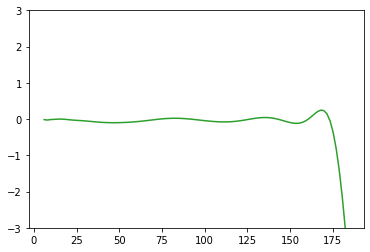

In [187]:
model = Sequential()
model.add(LSTM(8,input_shape=(5,1),return_sequences=False))#True = many to many
model.add(Dense(2,kernel_initializer="normal",activation="linear"))
model.add(Dense(1,kernel_initializer="normal",activation="linear"))
model.compile(loss="mse",optimizer ="adam",metrics=["accuracy"])
model.fit(X,y,epochs=2000,batch_size=5,validation_split=0.05,verbose=0);
scores = model.evaluate(X,y,verbose=1,batch_size=5)
print("Accurracy: {}".format(scores[1])) 
import matplotlib.pyplot as plt
predict=model.predict(X)
plt.plot(y, predict-y, 'C2')
plt.ylim(ymax = 3, ymin = -3)
plt.show()